In [73]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import style

from pathlib import Path

from autumn.settings import INPUT_DATA_PATH


If not in an 'AuTuMN' python environment. Edit and run the cell below to manually create the path to files.

In [74]:
style.use("dark_background")
p = Path(".")
# INPUT_DATA_PATH = p.joinpath('c:\\', "Users","maba0001", "AuTuMN", "data", "inputs")

In [75]:

fb_2021 = p.joinpath(INPUT_DATA_PATH, "mobility", "movement-range-2021.txt")
fb_2022 = p.joinpath(INPUT_DATA_PATH, "mobility", "movement-range-2022-04-25.txt")




In [76]:
df_list = []
for file in {fb_2021,fb_2022}:
    df = pd.read_csv(file, delimiter="\t")
    df = df[df["country"]=="BTN"]
    df_list.append(df)

fb_mov = pd.concat(df_list)

C:\Users\maba0001\AppData\Local\Temp\ipykernel_24204\195887657.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, delimiter="\t")
C:\Users\maba0001\AppData\Local\Temp\ipykernel_24204\195887657.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, delimiter="\t")


Take the average of all sub regions of Bhutan to arrive at national movement values.

In [77]:
btn_mov = fb_mov.groupby('ds', as_index=False).mean()

In [78]:
btn_mov.rename(columns={"all_day_bing_tiles_visited_relative_change":"visited_tiles","all_day_ratio_single_tile_users":"single_tiles" }, inplace=True)

Change the values of `MAP_FACOTRS` as required. 

In [79]:
MAP_FACTORS = {'retail_and_recreation_percent_change_from_baseline': 30,
       'grocery_and_pharmacy_percent_change_from_baseline': 20,
       'parks_percent_change_from_baseline': 20,
       'transit_stations_percent_change_from_baseline': 40,
       'workplaces_percent_change_from_baseline': 50,
       'residential_percent_change_from_baseline': 40}

In [80]:
for col, val in MAP_FACTORS.items():
    if col != 'residential_percent_change_from_baseline':
        btn_mov[col] = round(val * btn_mov["visited_tiles"],2)
    else:
        btn_mov[col] = round(val * btn_mov["single_tiles"],2)
        

In [81]:
btn_mov

,ds,visited_tiles,single_tiles,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,-0.031681,0.158795,-0.95,-0.63,-0.63,-1.27,-1.58,6.35
1,2020-03-02,-0.033898,0.147343,-1.02,-0.68,-0.68,-1.36,-1.69,5.89
2,2020-03-03,-0.024080,0.154181,-0.72,-0.48,-0.48,-0.96,-1.20,6.17
3,2020-03-04,0.011673,0.147913,0.35,0.23,0.23,0.47,0.58,5.92
4,2020-03-05,0.020682,0.142365,0.62,0.41,0.41,0.83,1.03,5.69
...,...,...,...,...,...,...,...,...,...
781,2022-04-21,-0.106540,0.160234,-3.20,-2.13,-2.13,-4.26,-5.33,6.41
782,2022-04-22,-0.117890,0.169758,-3.54,-2.36,-2.36,-4.72,-5.89,6.79
783,2022-04-23,-0.084266,0.157712,-2.53,-1.69,-1.69,-3.37,-4.21,6.31
784,2022-04-24,-0.069684,0.166292,-2.09,-1.39,-1.39,-2.79,-3.48,6.65


In [82]:
MOB_COL = [col for col in MAP_FACTORS.keys()]

<Figure size 360x360 with 0 Axes>

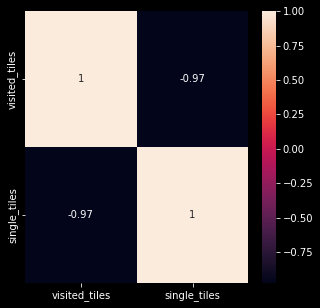

In [83]:
corr_plot = btn_mov[['visited_tiles', 'single_tiles']].corr()
plt.figure(figsize=(5,5))
hm = sns.heatmap(corr_plot, annot = True)

In [84]:
btn_mov.set_index(btn_mov['ds'], inplace= True)

<AxesSubplot:xlabel='ds'>

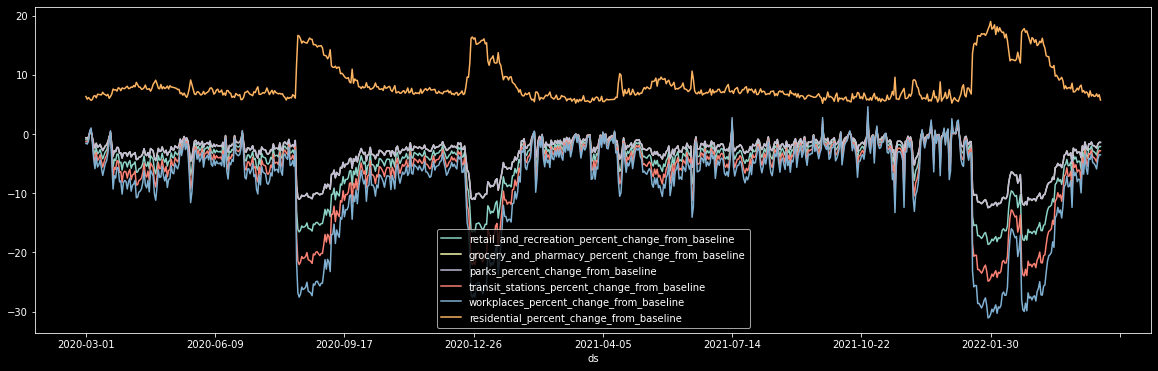

In [86]:
btn_mov[MOB_COL].plot(figsize=(20,6))

<AxesSubplot:xlabel='ds'>

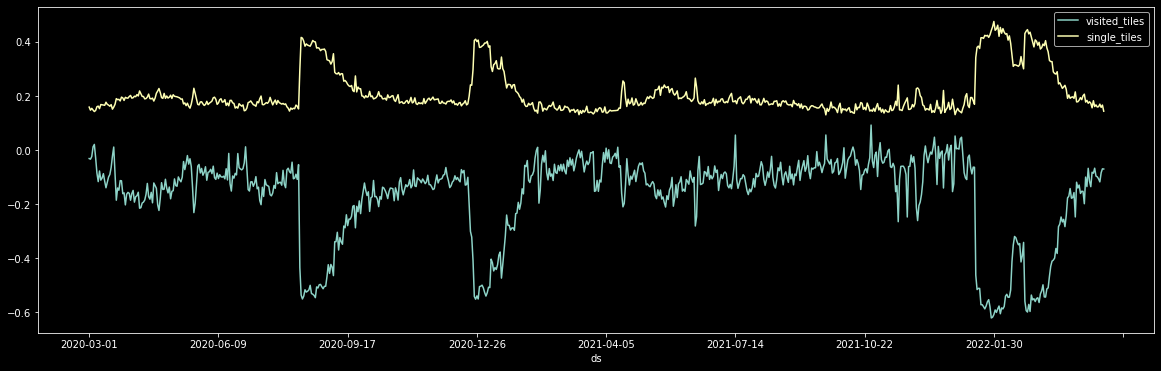

In [87]:
btn_mov[["visited_tiles","single_tiles"]].plot(figsize=(20,6))

Create a csv for input db.

In [88]:
btn_mov

,ds,visited_tiles,single_tiles,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
ds,,,,,,,,,
2020-03-01,2020-03-01,-0.031681,0.158795,-0.95,-0.63,-0.63,-1.27,-1.58,6.35
2020-03-02,2020-03-02,-0.033898,0.147343,-1.02,-0.68,-0.68,-1.36,-1.69,5.89
2020-03-03,2020-03-03,-0.024080,0.154181,-0.72,-0.48,-0.48,-0.96,-1.20,6.17
2020-03-04,2020-03-04,0.011673,0.147913,0.35,0.23,0.23,0.47,0.58,5.92
2020-03-05,2020-03-05,0.020682,0.142365,0.62,0.41,0.41,0.83,1.03,5.69
...,...,...,...,...,...,...,...,...,...
2022-04-21,2022-04-21,-0.106540,0.160234,-3.20,-2.13,-2.13,-4.26,-5.33,6.41
2022-04-22,2022-04-22,-0.117890,0.169758,-3.54,-2.36,-2.36,-4.72,-5.89,6.79
2022-04-23,2022-04-23,-0.084266,0.157712,-2.53,-1.69,-1.69,-3.37,-4.21,6.31


In [89]:
input_df = btn_mov[['ds']+MOB_COL]
input_df["sub_region_1"] = None

C:\Users\maba0001\AppData\Local\Temp\ipykernel_24204\3177104099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df["sub_region_1"] = None


In [90]:
#input_df.rename(columns=lambda x:  f"{x}_percent_change_from_baseline" if x not in {'ds',"polygon_name"} else x,inplace=True)
input_df.rename(columns={'ds':"date"}, inplace = True)
input_df["country_region"] = "Bhutan"

C:\Users\maba0001\AppData\Local\Temp\ipykernel_24204\4011003412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.rename(columns={'ds':"date"}, inplace = True)


In [ ]:
btn_csv = p.joinpath(INPUT_DATA_PATH, "mobility", "BTN_mobility.csv")

In [ ]:
input_df.to_csv(btn_csv, index=False)

Once the CSV is created run<br>
`python -m autumn db build`<br>
`python -m autumn secrets write data/inputs/inputs.secret.db`<br>
Git push the secret hash and the encrpyted db file to master.